In [1]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Dropout
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error

In [2]:
# zapobieganie wypisywania notacji naukowej przez numpy
np.set_printoptions(suppress=True)

https://stat.gov.pl/obszary-tematyczne/ceny-handel/wskazniki-cen/wskazniki-cen-towarow-i-uslug-konsumpcyjnych-pot-inflacja-/miesieczne-wskazniki-cen-towarow-i-uslug-konsumpcyjnych-od-1982-roku/

# Zbieranie i przygotowanie danych

### Załadowanie pliku z google drive

In [3]:
### Załadowanie dysku
# from google.colab import drive
# drive.mount('/content/drive')

In [4]:
# data_file = "/content/drive/My Drive/Colab Notebooks/miesieczne_wskazniki_cen_towarow_i_uslug_konsumpcyjnych_od_1982_roku.xlsx"

### Załadowanie pliku z dysku

In [5]:
from google.colab import files
uploaded = files.upload()
data_file = list(uploaded.keys())[0]

Saving miesieczne_wskazniki_cen_towarow_i_uslug_konsumpcyjnych_od_1982_roku.xlsx to miesieczne_wskazniki_cen_towarow_i_uslug_konsumpcyjnych_od_1982_roku (2).xlsx


### Filtracja danych

In [32]:
try:
  df = pd.read_excel(data_file)
  if "Sposób prezentacji" in df.columns:
      # Filtrowanie danych
      df_poprzedni_miesiac_100 = df[df["Sposób prezentacji"] == "Poprzedni miesiąc = 100"].copy()
      print("Wczytano dane i przefiltrowano według 'Sposób prezentacji' = 'Poprzedni miesiąc=100'.")
  else:
      print("Kolumna 'Sposób prezentacji' nie została znaleziona w pliku Excel.")
except FileNotFoundError:
    print(f"Błąd: Plik nie znaleziony pod ścieżką {data_file}")
except Exception as e:
    print(f"Wystąpił błąd podczas wczytywania pliku: {e}")

Wczytano dane i przefiltrowano według 'Sposób prezentacji' = 'Poprzedni miesiąc=100'.


In [74]:
data = df_poprzedni_miesiac_100[["Rok", "Miesiąc", "Wartość"]]
# pozbywamy się wierszy z wartościami NaN, występujące w roku 2025
data = data.dropna(subset=["Wartość"])
data = data.sort_values(by=['Rok','Miesiąc'], ascending=[1,1])

data_array = data.to_numpy()
print(data_array[149:])

[[1994.     6.   102.3]
 [1994.     7.   101.5]
 [1994.     8.   101.7]
 ...
 [2025.     2.   100.3]
 [2025.     3.   100.2]
 [2025.     4.   100.4]]


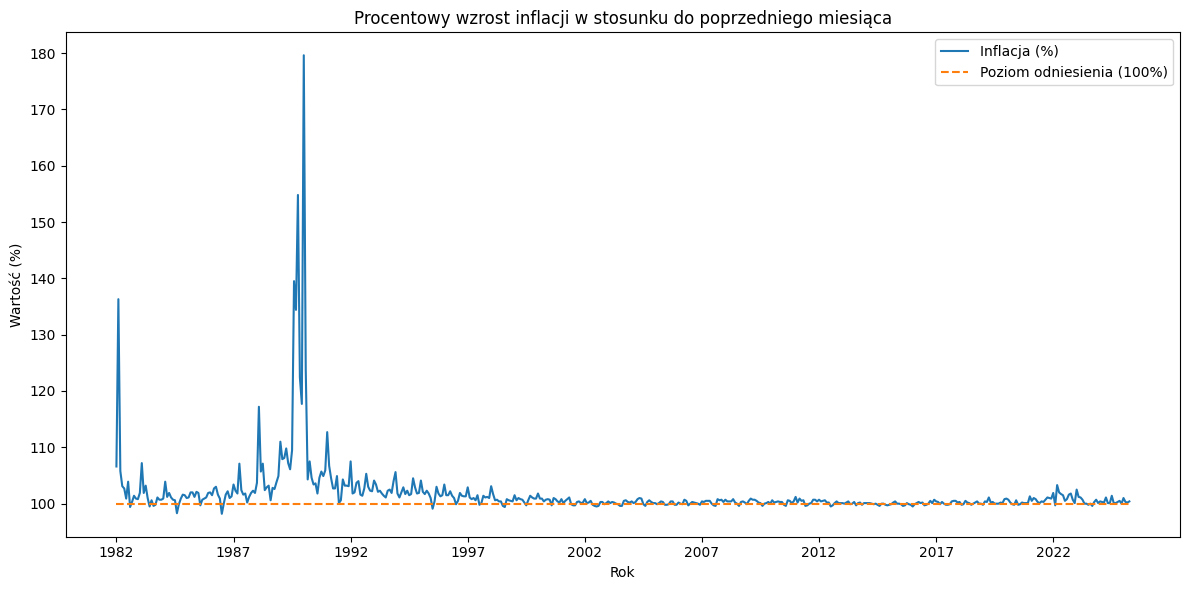

In [34]:
num_months = len(data_array)
end_date = pd.to_datetime("2025-04-01")
date_range = pd.date_range(end=end_date, periods=num_months, freq='MS')

fig, ax = plt.subplots(figsize=(12, 6))
ax.plot(np.arange(num_months), data_array[:, 2], label='Inflacja (%)')
ax.plot(np.arange(num_months), np.full(num_months, 100), linestyle='--', label='Poziom odniesienia (100%)')

tick_locs = np.arange(0, num_months, 60)
tick_labels = [date.strftime("%Y") for date in date_range[tick_locs]]
ax.set_xticks(tick_locs)
ax.set_xticklabels(tick_labels)

ax.set_xlabel("Rok")
ax.set_ylabel("Wartość (%)")
ax.set_title("Procentowy wzrost inflacji w stosunku do poprzedniego miesiąca")
ax.legend()
plt.tight_layout()
plt.show()

In [35]:
mean = np.mean(data_array[:, 2:3], axis=0)
sd = np.std(data_array[:, 2:3], axis=0)
top_limit = mean + 3 * sd
bottom_limit = mean - 3 * sd

for i in range(1,len(data_array)):
  value = data_array[i, 2]
  if value < bottom_limit or value > top_limit:
    data_array[i, 2] = data_array[i - 1, 2]

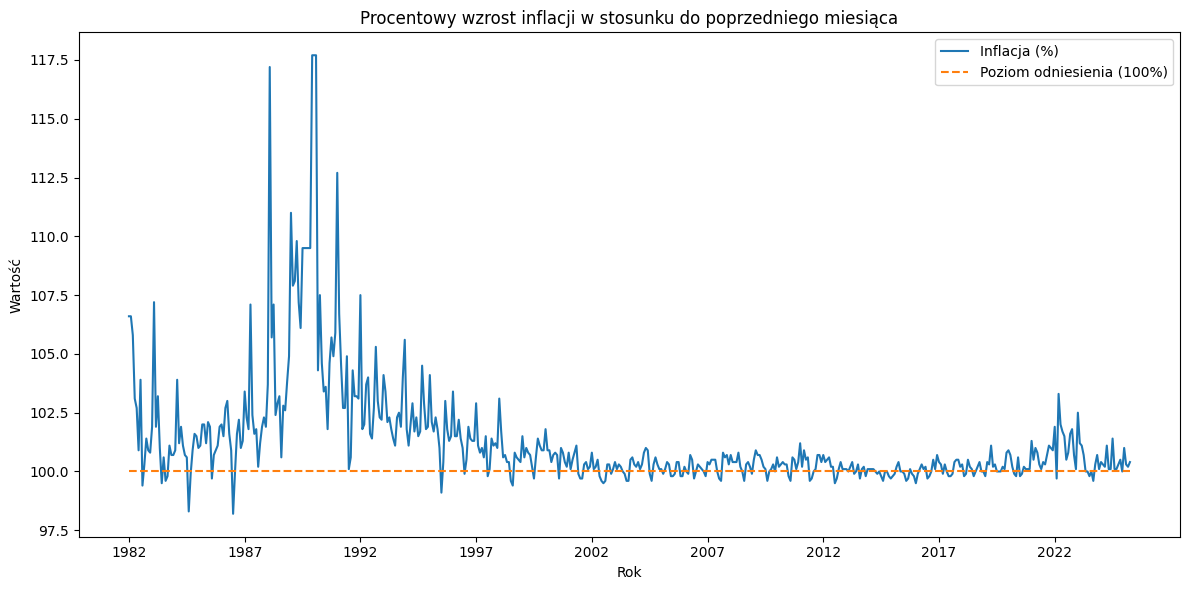

In [36]:
num_months = len(data_array)
end_date = pd.to_datetime("2025-04-01")
date_range = pd.date_range(end=end_date, periods=num_months, freq='MS')

tick_locs = np.arange(0, num_months, 60)
tick_labels = [date.strftime('%Y') for date in date_range[tick_locs]]

fig, ax = plt.subplots(figsize=(12, 6))
ax.plot(np.arange(num_months), data_array[:, 2], label='Inflacja (%)')
ax.plot(np.arange(num_months), np.full(num_months, 100), linestyle='--', label='Poziom odniesienia (100%)')

ax.set_xticks(tick_locs)
ax.set_xticklabels(tick_labels)
ax.set_xlabel("Rok")
ax.set_ylabel("Wartość")
ax.set_title("Procentowy wzrost inflacji w stosunku do poprzedniego miesiąca")
ax.legend()
plt.tight_layout()
plt.show()

## Zestaw 1 – Skala względem poprzedniego miesiąca od początku



In [75]:
data_1 = np.zeros((len(data_array), 2))
for i, row in enumerate(data_array):
    time_index = (int(row[0]) - 1982) * 12 + int(row[1])
    data_1[i] = [time_index, float(row[2])]

# --- Skalowanie danych ---
scaler = MinMaxScaler(feature_range=(0, 1))
inflation_scaled = scaler.fit_transform(data_1[:, 1].reshape(-1, 1))
data_scaled = np.hstack((data_1[:, 0].reshape(-1, 1), inflation_scaled))

## Zestaw 2 – Skala względem poprzedniego miesiąca od 150. indeksu

In [84]:
data_2 = data_1[149:].copy()

# --- Skalowanie danych ---
scaler = MinMaxScaler(feature_range=(0, 1))
inflation_scaled = scaler.fit_transform(data_2[:, 1].reshape(-1, 1))
data_scaled = np.hstack((data_2[:, 0].reshape(-1, 1), inflation_scaled))

## Zestaw 3 – Skala bezwzględna od początku

In [47]:
data_3 = np.zeros_like(data_1)
absolute_result = 1.0
data_3[0] = [data_1[0, 0], absolute_result]

for i in range(1, len(data_1)):
    change = (data_1[i, 1] - 100.0) / 100.0
    absolute_result += absolute_result * change
    data_3[i] = [data_1[i, 0], absolute_result]

# --- Skalowanie danych ---
scaler = MinMaxScaler(feature_range=(0, 1))
inflation_scaled = scaler.fit_transform(data_3[:, 1].reshape(-1, 1))
data_scaled = np.hstack((data_3[:, 0].reshape(-1, 1), inflation_scaled))

## Zestaw 4 – Skala bezwzględna od 150. indeksu

In [65]:
data_4 = np.zeros_like(data_1[149:])  # od indeksu 149 (czyli 150. rekord)

absolute_result = 1.0  # start od 1.0
data_4[0] = [data_1[149, 0], absolute_result]

for i in range(1, len(data_4)):
    change = (data_1[149 + i, 1] - 100.0) / 100.0
    absolute_result += absolute_result * change
    data_4[i] = [data_1[149 + i, 0], absolute_result]

# --- Skalowanie danych ---
scaler = MinMaxScaler(feature_range=(0, 1))
inflation_scaled = scaler.fit_transform(data_4[:, 1].reshape(-1, 1))
data_scaled = np.hstack((data_4[:, 0].reshape(-1, 1), inflation_scaled))

# **Model LSTM**

In [85]:
# --- Parametry modelu ---
WINDOW_SIZE = 6
TRAIN_RATIO = 0.8
FEATURES = 1  # jedna cecha: inflacja

# --- Przygotowanie danych sekwencyjnych ---
def prepare_data_seq(data, window_size):
    X, y = [], []
    for i in range(len(data) - window_size):
        X.append(data[i:i+window_size, 1])
        y.append(data[i+window_size, 1])
    return np.array(X), np.array(y)

X, y = prepare_data_seq(data_scaled, WINDOW_SIZE)

n_train = int(len(X) * TRAIN_RATIO)
X_train, X_test = X[:n_train], X[n_train:]
y_train, y_test = y[:n_train], y[n_train:]

X_train = X_train.reshape((X_train.shape[0], WINDOW_SIZE, FEATURES))
X_test = X_test.reshape((X_test.shape[0], WINDOW_SIZE, FEATURES))

In [86]:
# --- Budowa modelu ---
model = Sequential([
    LSTM(50, activation='tanh', input_shape=(WINDOW_SIZE, FEATURES)),
    Dropout(0.2),
    Dense(1, activation='linear')
])
model.compile(optimizer='adam', loss='mse')

# --- Trening modelu ---
early_stop = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

history = model.fit(
    X_train, y_train,
    epochs=50,
    batch_size=16,
    validation_split=0.1,
    callbacks=[early_stop],
    verbose=1
)

Epoch 1/50


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


17/17 ━━━━━━━━━━━━━━━━━━━━ 2s 25ms/step - loss: 0.0529 - val_loss: 0.0037
Epoch 2/50
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0118 - val_loss: 0.0032
Epoch 3/50
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0128 - val_loss: 0.0030
Epoch 4/50
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0121 - val_loss: 0.0032
Epoch 5/50
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0083 - val_loss: 0.0030
Epoch 6/50
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0120 - val_loss: 0.0028
Epoch 7/50
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0096 - val_loss: 0.0032
Epoch 8/50
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0115 - val_loss: 0.0028
Epoch 9/50
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0117 - val_loss: 0.0028
Epoch 10/50
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0120 - val_loss: 0.0030
Epoch 11/50
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0095 - val_loss: 0.0030
Epoch 12/50
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0112 - val_loss: 0.

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
RMSE na zbiorze uczącym: 0.5382
MAPE na zbiorze uczącym: 0.36%


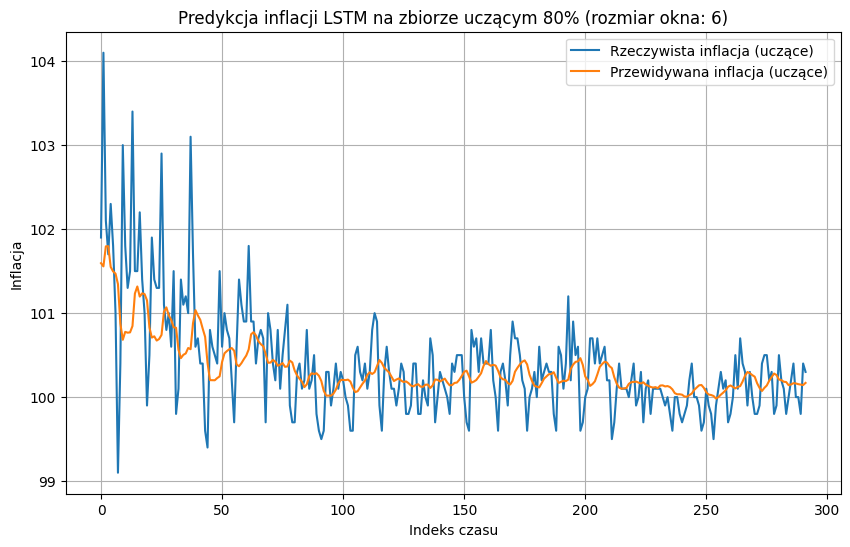

In [87]:
# --- Ewaluacja na zbiorze uczącym ---
y_train_pred_scaled = model.predict(X_train)
y_train_pred = scaler.inverse_transform(y_train_pred_scaled)
y_train_actual = scaler.inverse_transform(y_train.reshape(-1, 1))

rmse_train = np.sqrt(mean_squared_error(y_train_actual, y_train_pred))
mape_train = mean_absolute_percentage_error(y_train_actual, y_train_pred) * 100  # w %
print(f"RMSE na zbiorze uczącym: {rmse_train:.4f}")
print(f"MAPE na zbiorze uczącym: {mape_train:.2f}%")

plt.figure(figsize=(10, 6))
plt.plot(y_train_actual, label='Rzeczywista inflacja (uczące)')
plt.plot(y_train_pred, label='Przewidywana inflacja (uczące)')
plt.title(f'Predykcja inflacji LSTM na zbiorze uczącym {TRAIN_RATIO * 100:.0f}% (rozmiar okna: {WINDOW_SIZE})')
plt.xlabel('Indeks czasu')
plt.ylabel('Inflacja')
plt.legend()
plt.grid(True)
plt.show()

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
RMSE na zbiorze testowym: 0.6397
MAPE na zbiorze testowym: 0.45%


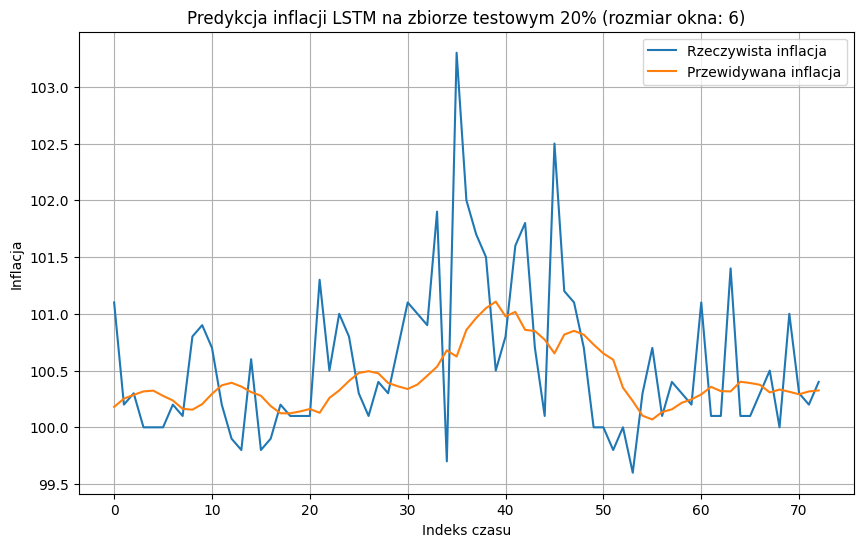

In [88]:
# --- Ewaluacja na zbiorze testowym ---
y_pred_scaled = model.predict(X_test)
y_pred = scaler.inverse_transform(y_pred_scaled)
y_test_actual = scaler.inverse_transform(y_test.reshape(-1, 1))

rmse_test = np.sqrt(mean_squared_error(y_test_actual, y_pred))
mape_test = mean_absolute_percentage_error(y_test_actual, y_pred) * 100  # w %
print(f"RMSE na zbiorze testowym: {rmse_test:.4f}")
print(f"MAPE na zbiorze testowym: {mape_test:.2f}%")

plt.figure(figsize=(10, 6))
plt.plot(y_test_actual, label='Rzeczywista inflacja')
plt.plot(y_pred, label='Przewidywana inflacja')
plt.title(f'Predykcja inflacji LSTM na zbiorze testowym {100 - TRAIN_RATIO * 100:.0f}% (rozmiar okna: {WINDOW_SIZE})')
plt.xlabel('Indeks czasu')
plt.ylabel('Inflacja')
plt.legend()
plt.grid(True)
plt.show()

In [89]:
# --- Predykcja 12 miesięcy do przodu ---
future_steps = 12
last_seq = X_test[-1]
predictions = []

for _ in range(future_steps):
    pred = model.predict(last_seq.reshape(1, WINDOW_SIZE, FEATURES), verbose=0)
    predictions.append(pred[0, 0])
    last_seq = np.roll(last_seq, -1)
    last_seq[-1] = pred[0, 0]

predictions_unscaled = scaler.inverse_transform(np.array(predictions).reshape(-1, 1))

# --- Trening na całych danych ---
X_all, y_all = prepare_data_seq(data_scaled, WINDOW_SIZE)
X_all = X_all.reshape((X_all.shape[0], WINDOW_SIZE, FEATURES))

model_full = Sequential([
    LSTM(50, activation='tanh', input_shape=(WINDOW_SIZE, FEATURES)),
    Dropout(0.2),
    Dense(1, activation='linear')
])
model_full.compile(optimizer='adam', loss='mse')

early_stop_full = EarlyStopping(monitor='loss', patience=10, restore_best_weights=True)

history_full = model_full.fit(
    X_all, y_all,
    epochs=50,
    batch_size=16,
    callbacks=[early_stop_full],
    verbose=1
)

Epoch 1/50


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


23/23 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 0.0515
Epoch 2/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0137
Epoch 3/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0155
Epoch 4/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0137
Epoch 5/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0116
Epoch 6/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0116
Epoch 7/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0093
Epoch 8/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0109
Epoch 9/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0105
Epoch 10/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0122
Epoch 11/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0104
Epoch 12/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0096
Epoch 13/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0113
Epoch 14/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0138
Epoch 15/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0120
Epoch 16/50
23/23 ━━━━━━━━━━━━

In [90]:
# --- Predykcja z modelu na całym zbiorze ---
future_steps_full = 12
last_seq_full = X_all[-1]
predictions_full = []

for _ in range(future_steps_full):
    pred = model_full.predict(last_seq_full.reshape(1, WINDOW_SIZE, FEATURES), verbose=0)
    predictions_full.append(pred[0, 0])
    last_seq_full = np.roll(last_seq_full, -1)
    last_seq_full[-1] = pred[0, 0]

predictions_full_unscaled = scaler.inverse_transform(np.array(predictions_full).reshape(-1, 1))

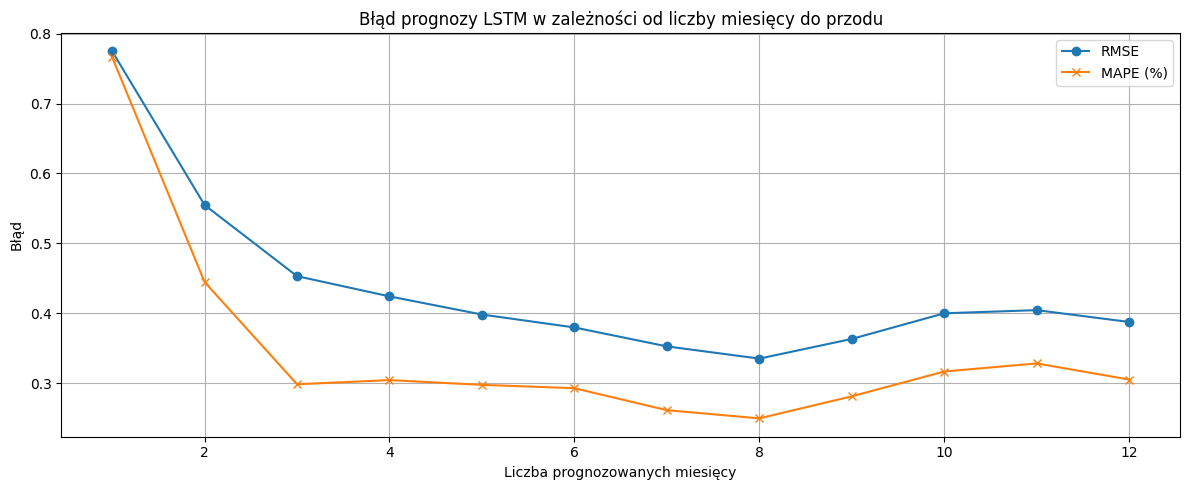

In [91]:
# --- Analiza błędu w funkcji liczby kroków ---
max_steps = 12
rmse_list, mape_list = [], []
last_seq_eval = X_test[-1].copy()

for steps in range(1, max_steps + 1):
    temp_seq = last_seq_eval.copy()
    preds = []

    for _ in range(steps):
        pred = model.predict(temp_seq.reshape(1, WINDOW_SIZE, FEATURES), verbose=0)
        preds.append(pred[0, 0])
        temp_seq = np.roll(temp_seq, -1)
        temp_seq[-1] = pred[0, 0]

    preds_unscaled = scaler.inverse_transform(np.array(preds).reshape(-1, 1))
    actual = y_test_actual[:steps].reshape(-1, 1)

    rmse = np.sqrt(mean_squared_error(actual, preds_unscaled))
    mape = mean_absolute_percentage_error(actual, preds_unscaled) * 100  # w %

    rmse_list.append(rmse)
    mape_list.append(mape)

# --- Wykres RMSE i MAPE ---
plt.figure(figsize=(12, 5))
plt.plot(range(1, max_steps + 1), rmse_list, marker='o', label='RMSE')
plt.plot(range(1, max_steps + 1), mape_list, marker='x', label='MAPE (%)')
plt.title("Błąd prognozy LSTM w zależności od liczby miesięcy do przodu")
plt.xlabel("Liczba prognozowanych miesięcy")
plt.ylabel("Błąd")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

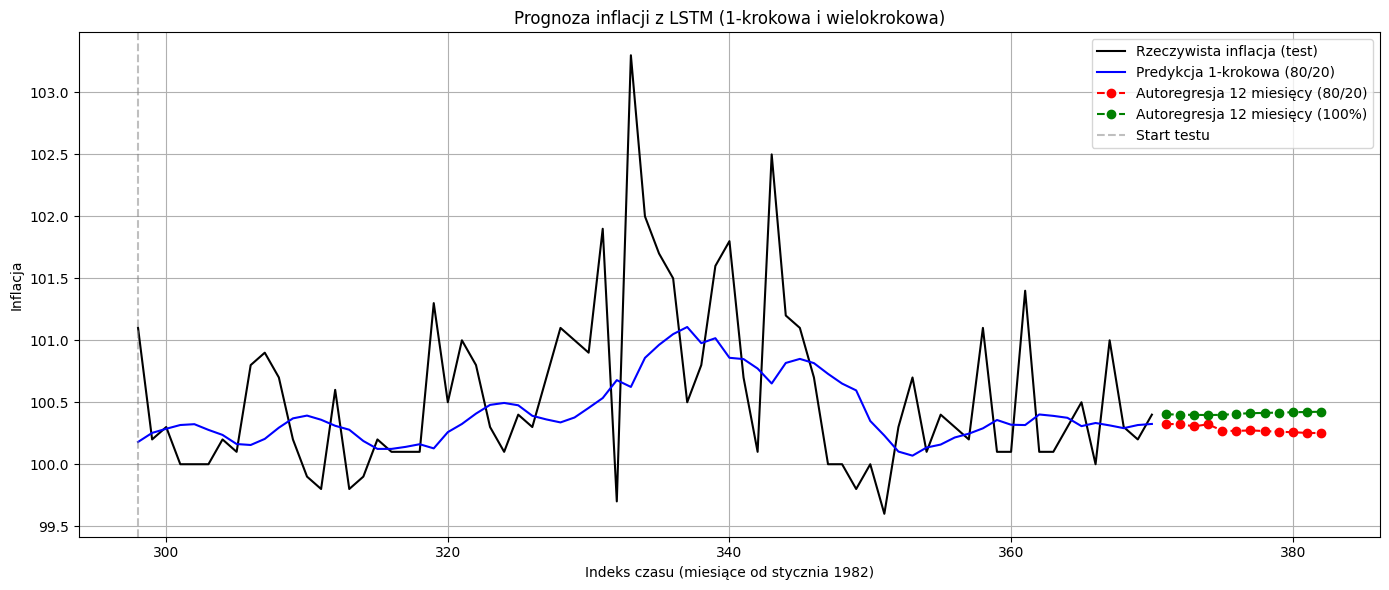

In [92]:
# --- Wykres końcowy z predykcjami ---
plt.figure(figsize=(14, 6))

x_test = np.arange(len(data_scaled) - len(y_test_actual), len(data_scaled))
x_pred = x_test[:len(y_pred)]
x_future = np.arange(len(data_scaled), len(data_scaled) + future_steps)
x_full_future = np.arange(len(data_scaled), len(data_scaled) + future_steps_full)

plt.plot(x_test, y_test_actual, label='Rzeczywista inflacja (test)', color='black')
plt.plot(x_pred, y_pred, label='Predykcja 1-krokowa (80/20)', color='blue')
plt.plot(x_future, predictions_unscaled, '--o', label='Autoregresja 12 miesięcy (80/20)', color='red')
plt.plot(x_full_future, predictions_full_unscaled, '--o', label='Autoregresja 12 miesięcy (100%)', color='green')

plt.axvline(x=x_test[0], color='gray', linestyle='--', alpha=0.5, label='Start testu')
plt.title('Prognoza inflacji z LSTM (1-krokowa i wielokrokowa)')
plt.xlabel('Indeks czasu (miesiące od stycznia 1982)')
plt.ylabel('Inflacja')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()
